In [2]:
from dataclasses import dataclass
from math import hypot, cos, sin

import numpy as np
import matplotlib.pyplot as plt

In [17]:
@dataclass(frozen=True, slots=True)
class Point:
    x: float
    y: float

    @classmethod
    def origin(cls):
        return cls(0, 0)
    
    @classmethod
    def from_array(cls, arr):
        x, y = arr.flatten()
        return cls(x, y)

    def to_array(self):
        return np.array([[self.x], [self.y]])

    def __abs__(self):
        return hypot(self.x, self.y)

    def __neg__(self):
        _type = type(self)
        return _type(-self.x, -self.y)

    def __add__(self, other):
        _type = type(self)
        if type(other) == _type:
            return _type(self.x + other.x, self.y + other.y)
        else:
            return NotImplemented
        
    def __sub__(self, other):
        _type = type(self)
        if type(other) == _type:
            return _type(self.x - other.x, self.y - other.y)
        else:
            return NotImplemented

@dataclass(frozen=True, slots=True)
class CurveSegment:
    length: float
    curvature: float

    @property
    def ang(self):
        return self.length * self.curvature

    @property
    def end(self) -> Point:
        if self.curvature == 0:
            return Point(self.length, 0)
        else:
            angle = self.ang
            radius = 1 / self.curvature
            return Point(radius * sin(angle), radius * (1 - cos(angle)))
    
    def __len__(self):
        return self.length
    
    def to_array(self, density=50, start=Point.origin(), angle=0):
        n = int(self.length * density)
        out = np.zeros((2, n))

        if self.curvature == 0:
            out[0, :] = np.linspace(0, self.length, n)
        else:
            radius = 1 / self.curvature
            ang_step = self.length * self.curvature / n
            angles = ang_step * np.arange(n)
            out[0, :] = np.sin(angles)
            out[1, :] = 1 - np.cos(angles)
            out *= radius
        
        rotm = np.array([[+np.cos(angle), -np.sin(angle)],
                         [+np.sin(angle), +np.cos(angle)]])
        out = rotm @ out

        out += start.to_array()
        return out
    
class Line(CurveSegment):
    def __init__(self, length):
        super().__init__(length, 0)

class Arc(CurveSegment):
    def __init__(self, radius, angle, *, deg=False):
        if deg: angle *= np.pi/180
        super().__init__(radius*abs(angle), 1/radius)

@dataclass(frozen=True, slots=True)
class Curve:
    start: Point
    angle: float = 0
    segments: tuple = ()

    @property
    def end(self):
        rotm = np.array([[+np.cos(self.angle), -np.sin(self.angle)],
                         [+np.sin(self.angle), +np.cos(self.angle)]])
        end = sum((segm.end for segm in self.segments), start=Point.origin())
        end = Point.from_array(rotm @ end.to_array())
        end += self.start
        return end
    
    @property
    def junctions(self):
        rotm = lambda ang: np.array([[+np.cos(ang), -np.sin(ang)],
                                     [+np.sin(ang), +np.cos(ang)]])
        point, angle = self.start, self.angle
        yield point, angle
        for segm in self.segments:
            point += Point.from_array(rotm(angle) @ segm.end.to_array())
            angle += segm.ang
            yield point, angle

    def to_array(self, density=50):
        out = np.concatenate([segm.to_array(density, start, angle).T
                              for (start, angle), segm in zip(self.junctions, self.segments)])
        return out

    def __len__(self):
        return sum(map(len, self.segments))
    
    def __add__(self, other):
        if isinstance(other, CurveSegment):
            return Curve(self.start, self.angle, self.segments + (other,))
        else:
            return NotImplemented

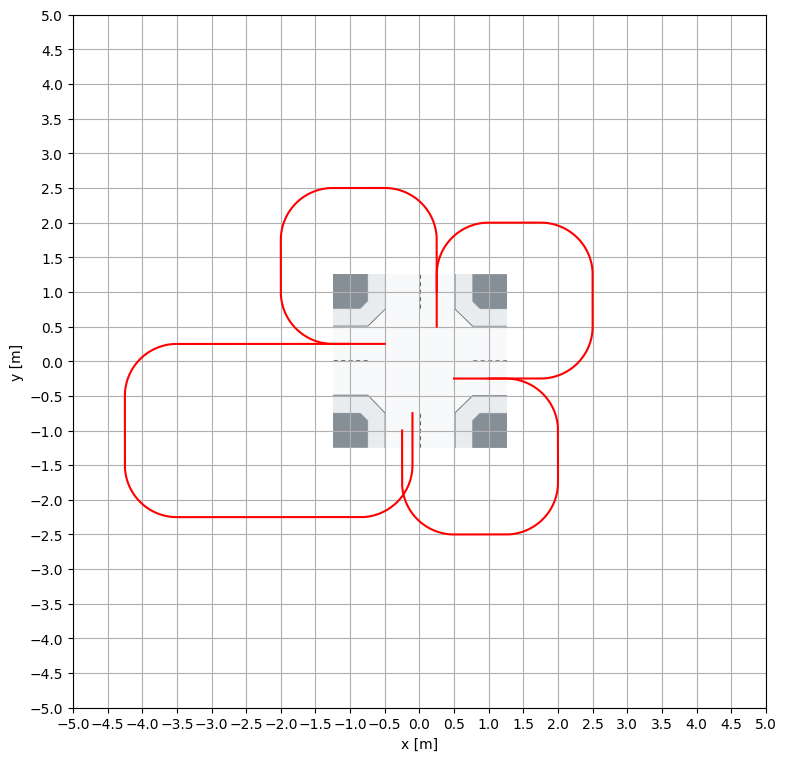

In [24]:
# Matplotlib plotting

def plot_curve(ax, curve, color='red'):
    # for pnt in curve.junctions:
    #     ax.plot(pnt.x, pnt.y, 'ko', markersize=4)

    # arw_x, arw_y = 1.5*cos(curve.angle) - curve.start.x, 1.5*sin(curve.angle) - curve.start.y
    # ax.quiver(arw_x, arw_y, curve.start.x, curve.start.y, angles='xy', scale_units='xy', scale=1, color='gray')

    x, y = curve.to_array().T
    ax.plot(x, y, '-', color=color)

def main():
    bgpath = '../data/4way.png'

    fig, ax = plt.subplots(1, 1, figsize=(9*4/3, 9))
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    ax.imshow(plt.imread(bgpath), extent=[-1.25, 1.25, -1.25, 1.25])

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.set_xticks(np.arange(-5, 5+0.1, 0.5))
    ax.set_yticks(np.arange(-5, 5+0.1, 0.5))
    ax.grid(True)

    # curve = Curve(Point.origin())
    # # curve += Line(1)
    # curve += Arc(1, np.pi/2)
    # plot_curve(ax, curve)

    if True:
    
        save = {}

        # Close to container
        curve = Curve(Point(1, -0.25))
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        plot_curve(ax, curve)
        save['exit_e'] = curve.to_array()

        # Right from container
        curve = Curve(Point(0.25, 1), np.pi/2)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        plot_curve(ax, curve)
        save['exit_n'] = curve.to_array()

        # Left from container
        curve = Curve(Point(-0.25, -1), -np.pi/2)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        plot_curve(ax, curve)
        save['exit_s'] = curve.to_array()

        # Annika's long road
        curve = Curve(Point(-1, 0.25), np.pi)
        curve = curve + Line(2.5)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(1)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(2.65)
        curve = curve + Arc(0.75, -90, deg=True)
        curve = curve + Line(0.75)
        plot_curve(ax, curve)
        save['exit_w'] = curve.to_array()

        np.savez('clovers.npz', **save)

main()